## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import warnings
import random
import glob
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Reshape

## Load the Dataset

In [2]:
TRAIN_DIR = r"C:\Users\admin\Documents\ds-python\cnn\images"
TEST_DIR = r"C:\Users\admin\Documents\ds-python\cnn\emoji"

In [3]:
import os
import cv2
from keras.preprocessing.image import img_to_array

# Set the desired dimensions for image resizing
img_dims = (48, 48)  # Example dimensions; modify as needed

# Function to load dataset from a single directory
def load_dataset(directory):
    image_paths = []
    labels = []
    data = []  # Initialize data list

    # Loop through each label (subdirectory)
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)  # Create the full path to the label directory

        if os.path.isdir(label_path):  # Check if it's a directory
            for filename in os.listdir(label_path):  # List files in the label directory
                image_path = os.path.join(label_path, filename)  # Full path to the image file
                image = cv2.imread(image_path)  # Read the image
                
                # Check if the image was loaded successfully
                if image is not None:
                    image = cv2.resize(image, img_dims)  # Resize the image
                    image = img_to_array(image)  # Convert to numpy array
                    data.append(image)  # Append the image to the data list
                    image_paths.append(image_path)  # Append the image path to the list
                    labels.append(label)  # Append the label

            print(label, "Completed")
    
    return image_paths, labels, data  # Return image paths, labels, and loaded data

In [4]:
# Load training data
train_image_paths, train_labels, train_data = load_dataset(TRAIN_DIR)

# Create a DataFrame from the loaded data
train = pd.DataFrame({'image': train_image_paths, 'label': train_labels})

# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)

# Display the first few rows
print(train.head())

angry Completed
fear Completed
happy Completed
sad Completed
                                               image  label
0  C:\Users\admin\Documents\ds-python\cnn\images\...  happy
1  C:\Users\admin\Documents\ds-python\cnn\images\...  angry
2  C:\Users\admin\Documents\ds-python\cnn\images\...    sad
3  C:\Users\admin\Documents\ds-python\cnn\images\...   fear
4  C:\Users\admin\Documents\ds-python\cnn\images\...   fear


In [5]:
# Load training data
test_image_paths, test_labels, test_data = load_dataset(TEST_DIR)

# Create a DataFrame from the loaded data
test = pd.DataFrame({'image': test_image_paths, 'label': test_labels})

# Shuffle the dataset
test = test.sample(frac=1).reset_index(drop=True)

# Display the first few rows
print(test.head())


angry Completed
fear Completed
happy Completed
sad Completed
                                               image  label
0  C:\Users\admin\Documents\ds-python\cnn\emoji\h...  happy
1  C:\Users\admin\Documents\ds-python\cnn\emoji\f...   fear
2  C:\Users\admin\Documents\ds-python\cnn\emoji\a...  angry
3  C:\Users\admin\Documents\ds-python\cnn\emoji\a...  angry
4  C:\Users\admin\Documents\ds-python\cnn\emoji\h...  happy


<Axes: xlabel='label', ylabel='count'>

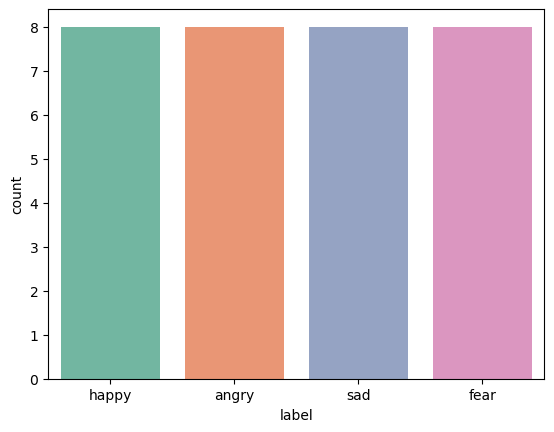

In [6]:
sns.countplot(x=train['label'],palette='Set2')

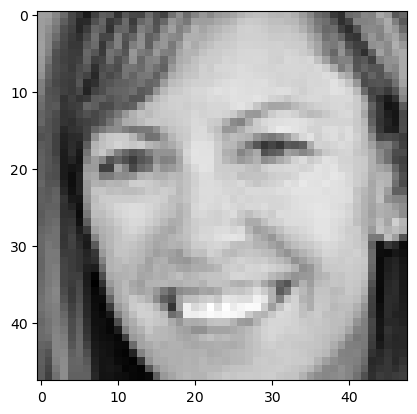

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

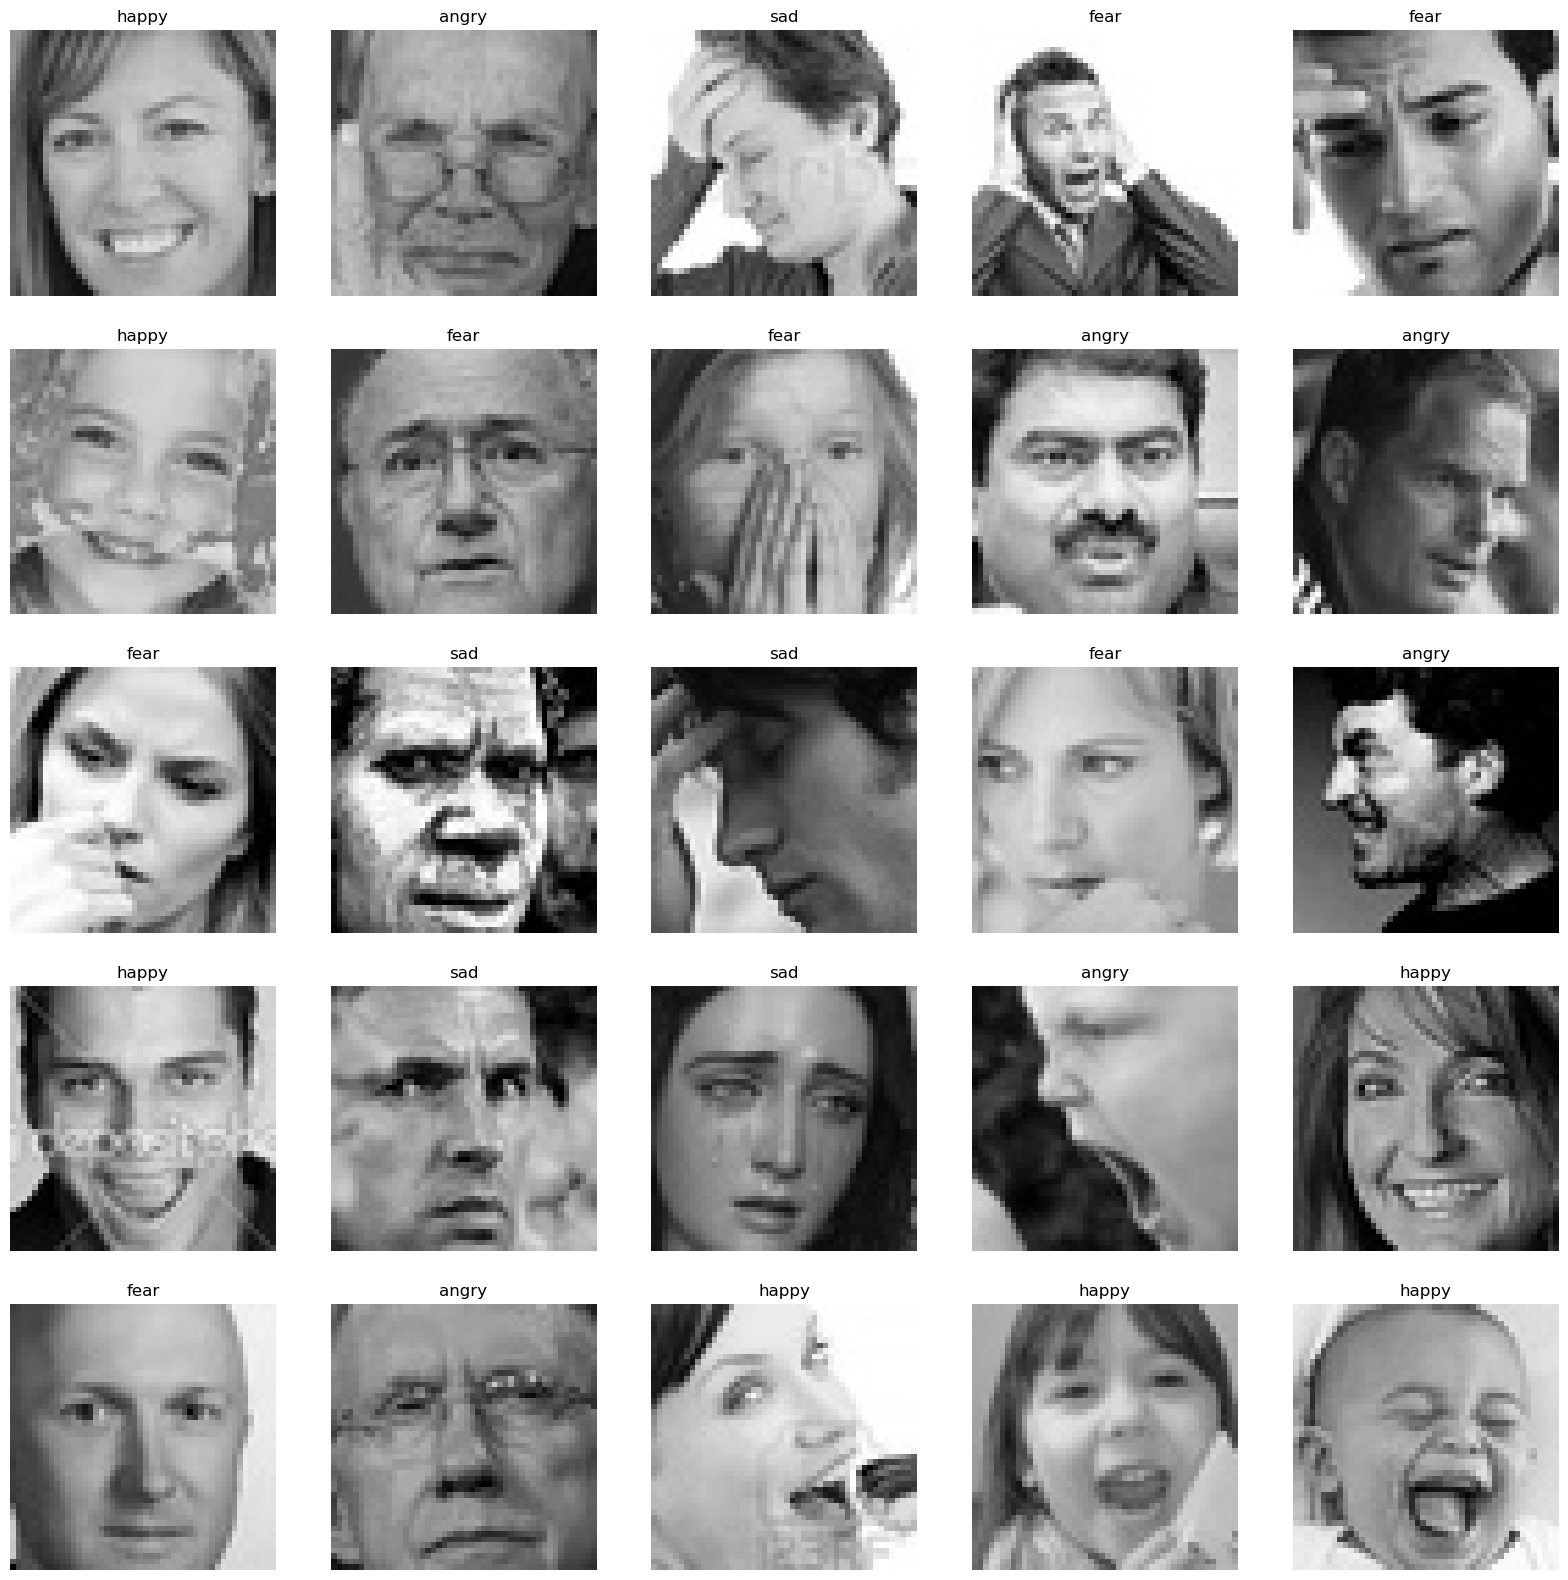

In [8]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [9]:
# Function to extract features
def extract_features(images):
    features = []
    
    for image in tqdm(images, desc="Extracting features"):
        try:
            img = load_img(image, color_mode='grayscale', target_size=(48, 48))
            img = img_to_array(img)
            features.append(img)
        except Exception as e:
            print(f"Error loading image {image}: {e}")

    features = np.array(features).reshape(len(features),48,48,1)
    
    return features

In [10]:
# Extract features
train_features = extract_features(train['image'])

Extracting features:   0%|          | 0/32 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

Extracting features:   0%|          | 0/32 [00:00<?, ?it/s]

In [12]:
# Normalize the images
x_train = train_features / 255.0
x_test = test_features / 255.0

In [13]:
# Convert labels to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])

In [14]:
# One-hot encode labels
y_train = to_categorical(y_train, num_classes = len(le.classes_))
y_test = to_categorical(y_test, num_classes = len(le.classes_))

In [15]:
# Model configuration
input_shape = (48, 48, 1)
output_class = 4

## Model Creation

In [16]:
model = Sequential()
# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='elu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
# Fully connected layers
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(output_class, activation='softmax'))  # For multi-class classification


In [17]:
# Compile the model with categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model
history = model.fit(x=x_train, y=y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2812 - loss: 1.4497 - val_accuracy: 0.2500 - val_loss: 1.4298
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step - accuracy: 0.2188 - loss: 1.6180 - val_accuracy: 0.2500 - val_loss: 3.0122
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step - accuracy: 0.2812 - loss: 3.5911 - val_accuracy: 0.1562 - val_loss: 1.8578
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step - accuracy: 0.2812 - loss: 3.1737 - val_accuracy: 0.2500 - val_loss: 4.5189
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step - accuracy: 0.2500 - loss: 3.6433 - val_accuracy: 0.2500 - val_loss: 6.4408
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step - accuracy: 0.2500 - loss: 4.1559 - val_accuracy: 0.2500 - val_loss: 6.1835
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step - accuracy: 0.2500 - loss: 4.2598 - val_accuracy: 0.2500 - val_loss: 5.0934
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step - accuracy: 0.2188 - loss: 4.5012 - val_accuracy: 0.2500 - val_

## Plot the Results

<Figure size 640x480 with 0 Axes>

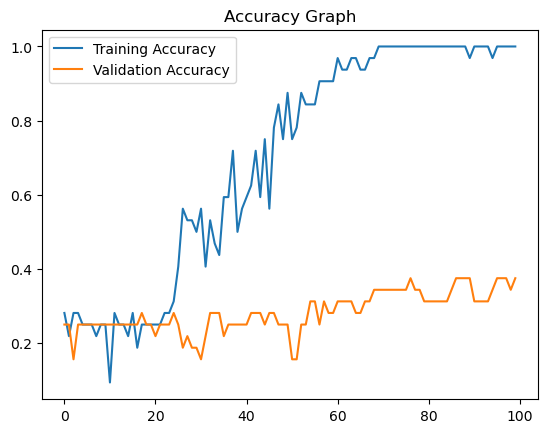

<Figure size 640x480 with 0 Axes>

In [19]:
# Visualize accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

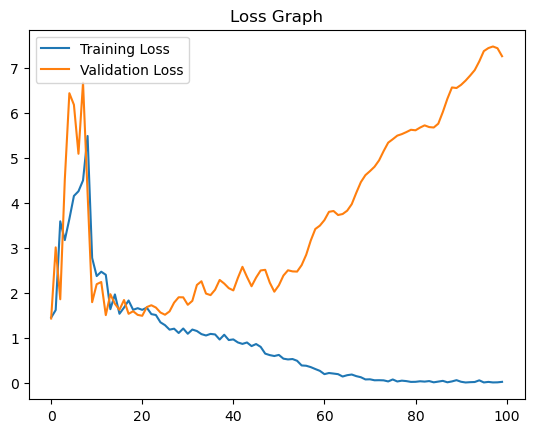

In [20]:
# Visualize loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Test with Image Data

Original Output: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Predicted Output: angry


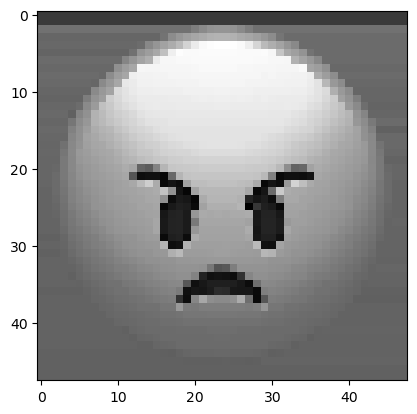

In [21]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')

## THANK YOU